# Spike sort

Notebook within the chronic ephys processing pipeline
- 1-preprocess_acoustics
- 2-curate_acoustics
- **3-sort_spikes**
- 4-curate_spikes

Use the environment **spikeproc** to run this notebook

In [1]:
import numpy as np
import os
import pickle
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/chronic_ephys/code/npy-matlab'
os.environ["KILOSORT2_PATH"] = '/mnt/cube/chronic_ephys/code/Kilosort2'
os.environ["KILOSORT3_PATH"] = '/mnt/cube/chronic_ephys/code/Kilosort'
import spikeinterface.full as si
import sys
import traceback
sys.path.append('/mnt/cube/lo/envs/ceciestunepipe/')
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.mods import probe_maps as pm

## Set parameters

In [2]:
si.get_default_sorter_params('kilosort4')

{'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'do_CAR': True,
 'invert_sign': False,
 'nt': 61,
 'artifact_threshold': None,
 'nskip': 25,
 'whitening_range': 32,
 'binning_depth': 5,
 'sig_interp': 20,
 'nt0min': None,
 'dmin': None,
 'dminx': None,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'cluster_pcs': 64,
 'duplicate_spike_bins': 15,
 'do_correction': True,
 'keep_good_only': False,
 'save_extra_kwargs': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None}

#### Set `dmin` and `dminx`
**Setting these appropriately will greatly reduce sort time**
- The default value for dmin is the median distance between contacts -- if contacts are irregularly spaced, like in a modular Neuropixels 2.0 setup, will need to specify a value
- The default for dminx is 32um (designed for Neuropixels probes)

Support documentation [here](https://kilosort.readthedocs.io/en/latest/parameters.html#dmin-and-dminx)

In [3]:
# non default spike sorting parameters
sort_params_dict_ks3 = {'minFR':0.001, 'minfr_goodchannels':0.001} # kilosort 3
sort_params_dict_ks4_npx = {'nblocks':5, 'Th_universal':8, 'Th_learned':7, 'dmin':15, 'dminx':32} # kilosort 4, neuropixels (set dmin and dminx to true pitch)
sort_params_dict_ks4_nnx64 = {'nblocks':0, 'nearest_templates':64,
                              'Th_universal':8, 'Th_learned':7} # kilosort 4, neuronexus 64 chan

# waveform extraction parameters
wave_params_dict = {'ms_before':1, 'ms_after':2, 'max_spikes_per_unit':500,
                    'sparse':True, 'num_spikes_for_sparsity':100, 'method':'radius',
                    'radius_um':40, 'n_components':5, 'mode':'by_channel_local'}

# print stuff
verbose = True

# errors break sorting
raise_error = False

# restrict sorting to a specific GPU
restrict_to_gpu = 1 # 0 1 None

# use specific GPU if specified
if restrict_to_gpu is not None:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)

# parallel processing params
job_kwargs = dict(n_jobs=28,chunk_duration="1s",progress_bar=False)
si.set_global_job_kwargs(**job_kwargs)

# force processing of previous failed sorts
skip_failed = False

In [4]:
bird_rec_dict = {
    'z_p5y10_23':[
        {'sess_par_list':['2024-05-16'], # sessions (will process all epochs within)
         'probe':{'probe_type':'neuropixels-2.0'}, # probe specs
         'sort':'sort_0', # label for this sort instance
         'sorter':'kilosort4', # sort method
         'sort_params':sort_params_dict_ks4_npx, # non-default sort params
         'wave_params':wave_params_dict, # waveform extraction params
         'ephys_software':'sglx' # sglx or oe
        },
    ],
}

## Run sorts

In [10]:
%%time

# store sort summaries
sort_summary_all = []

# loop through all birds / recordings
for this_bird in bird_rec_dict.keys():
    # get session configurations
    sess_all = bird_rec_dict[this_bird]
    
    # loop through session configurations
    for this_sess_config in sess_all:
        
        # loop through sessions
        for this_sess in this_sess_config['sess_par_list']:
            log_dir = os.path.join('/mnt/cube/chronic_ephys/log', this_bird, this_sess)
            
            # build session parameter dictionary
            sess_par = {'bird':this_bird,
                        'sess':this_sess,
                        'ephys_software':this_sess_config['ephys_software'],
                        'sorter':this_sess_config['sorter'],
                        'sort':this_sess_config['sort']}
            # get epochs
            sess_epochs = et.list_ephys_epochs(sess_par)
            
            for this_epoch in sess_epochs:
                
                # set output directory
                epoch_struct = et.sgl_struct(sess_par,this_epoch,ephys_software=sess_par['ephys_software'])
                sess_par['epoch'] = this_epoch
                sort_folder = epoch_struct['folders']['derived'] + '/{}/{}/'.format(sess_par['sorter'],sess_par['sort'])
                
                # get spike sort log
                try:
                    with open(os.path.join(log_dir, this_epoch+'_spikesort_'+this_sess_config['sort']+'.log'), 'r') as f:
                        log_message=f.readline() # read the first line of the log file
                    if log_message[:-1] == sess_par['bird']+' '+sess_par['sess']+' sort complete without error':
                        print(sess_par['bird'],sess_par['sess'],'already exists -- skipping sort')
                        run_proc = False
                    elif log_message[:-1] == sess_par['bird']+' '+sess_par['sess']+' sort failed':
                        if skip_failed:
                            print(sess_par['bird'],sess_par['sess'],'previously failed -- skipping sort')
                            run_proc = False
                        else:
                            run_proc = True
                    else: # uninterpretable log file
                        run_proc = True
                except: # no existing log file
                    run_proc = True
                
                # run sort
                if run_proc:
#                     try:
                    print('___________',this_bird,this_sess,this_epoch,'___________')
                    # prepare recording for sorting
                    print('prep..')
                    if sess_par['ephys_software'] == 'sglx':
                        # load recording
                        rec_path = epoch_struct['folders']['sglx']
                        this_rec = si.read_spikeglx(folder_path=rec_path,stream_name='imec0.ap')
                        # save probe map prior to re-ordering for sorting
                        probe_df = this_rec.get_probe().to_dataframe()
#                         probe_df.to_pickle(os.path.join(epoch_struct['folders']['derived'],'probe_map_df.pickle'))
                        # ibl destriping
                        this_rec = si.highpass_filter(recording=this_rec)
                        this_rec = si.phase_shift(recording=this_rec)
                        bad_good_channel_ids = si.detect_bad_channels(recording=this_rec)
                        if len(bad_good_channel_ids[0]) > 0:
                            this_rec = si.interpolate_bad_channels(recording=this_rec,bad_channel_ids=bad_good_channel_ids[0])
                        if this_sess_config['probe']['probe_type'] == 'neuropixels-2.0':
                            # highpass by shank
                            split_rec = this_rec.split_by(property='group',outputs='list') # split recording by shank
                            split_rec = [si.highpass_spatial_filter(recording=r,n_channel_pad=min(r.get_num_channels(),60)) for r in split_rec]
                            this_rec_p = si.aggregate_channels(split_rec) # recombine shanks
#                                 # stack shanks
                            p,_ = stack_shanks(probe_df) # make new Probe object with shanks stacked
                            this_rec_p = this_rec.set_probe(p,group_mode='by_probe') # assign new Probe object to probe
                        else:
                            this_rec_p = si.highpass_spatial_filter(recording=this_rec)
#                         elif sess_par['ephys_software'] =='oe':
#                             # load recording
#                             rec_path = [f.path for f in os.scandir(epoch_struct['folders']['oe']) if f.is_dir()][0]
#                             this_rec = si.read_openephys(folder_path=rec_path)
#                             # add probe
#                             this_probe = pm.make_probes(this_sess_config['probe']['probe_type'],this_sess_config['probe']['probe_model']) # neuronexus, Buzsaki64
#                             this_rec_p = this_rec.set_probe(this_probe,group_mode='by_shank')
#                         # set sort params
#                         this_rec_p = si.concatenate_recordings([this_rec_p])
#                         sort_params = si.get_default_sorter_params(this_sess_config['sorter'])
#                         for this_param in this_sess_config['sort_params'].keys():
#                             sort_params[this_param] = this_sess_config['sort_params'][this_param]
#                         # run sort
#                         print('sort..')
#                         this_sort = si.run_sorter(sorter_name=this_sess_config['sorter'],recording=this_rec_p,output_folder=sort_folder,
#                                              remove_existing_folder=True,delete_output_folder=False,delete_container_files=False,
#                                              verbose=verbose,raise_error=raise_error,**sort_params)
#                         # bandpass recording before waveform extraction
#                         print('bandpass..')
#                         this_rec_pf = si.bandpass_filter(recording=this_rec_p)
#                         # extract waveforms
#                         print('waveform..')
#                         wave_params = this_sess_config['wave_params']
#                         wave = si.extract_waveforms(this_rec_pf,this_sort,folder=os.path.join(sort_folder,'waveforms'),
#                                                     ms_before=wave_params['ms_before'],ms_after=wave_params['ms_after'],
#                                                     max_spikes_per_unit=wave_params['max_spikes_per_unit'],
#                                                     sparse=wave_params['sparse'],num_spikes_for_sparsity=wave_params['num_spikes_for_sparsity'],
#                                                     method=wave_params['method'],radius_um=wave_params['radius_um'],overwrite=True,**job_kwargs)
#                         # compute metrics
#                         print('metrics..')
#                         loc = si.compute_unit_locations(waveform_extractor=wave)
#                         cor = si.compute_correlograms(waveform_or_sorting_extractor=wave)
#                         sim = si.compute_template_similarity(waveform_extractor=wave)
#                         amp = si.compute_spike_amplitudes(waveform_extractor=wave,**job_kwargs)
#                         pca = si.compute_principal_components(waveform_extractor=wave,n_components=wave_params['n_components'],
#                                                               mode=wave_params['mode'],**job_kwargs)
#                         qms = si.get_quality_metric_list()
#                         metric_names = []
#                         bad_metrics = []
#                         for qm in qms:
#                             try:
#                                 si.compute_quality_metrics(waveform_extractor=wave,verbose=False,metric_names=[qm],**job_kwargs)
#                                 metric_names.append(qm)
#                             except:
#                                 bad_metrics.append(qm)
#                         met = si.compute_quality_metrics(waveform_extractor=wave,verbose=verbose,metric_names=metric_names,**job_kwargs)

#                         # mark complete
#                         print('COMPLETE!!')

#                         # log complete sort
#                         if not os.path.exists(log_dir): os.makedirs(log_dir)
#                         with open(os.path.join(log_dir, this_epoch+'_spikesort_'+this_sess_config['sort']+'.log'), 'w') as f:
#                             f.write(sess_par['bird']+' '+sess_par['sess']+' sort complete without error\n\n')
#                             f.write('Sort method: '+this_sess_config['sorter']+'\n\n')
#                             f.write('Sort params: '+str(sort_params)+'\n\n')
#                             f.write('Computed quality metrics: '+str(metric_names)+'\n\n')
#                             f.write('Failed quality metrics: '+str(bad_metrics)+'\n')
#                         sort_summary = [this_bird,this_sess,sess_par['ephys_software'],this_epoch,'COMPLETE']
                    
#                     except Exception as e:
#                         # mark exception
#                         print("An exception occurred:", e)
                        
#                         # log failed sort
#                         if not os.path.exists(log_dir): os.makedirs(log_dir)
#                         with open(os.path.join(log_dir, this_epoch+'_spikesort_'+this_sess_config['sort']+'.log'), 'w') as f:
#                             f.write(sess_par['bird']+' '+sess_par['sess']+' sort failed\n')
#                             f.write(traceback.format_exc())
#                         sort_summary = [this_bird,this_sess,sess_par['ephys_software'],this_epoch,'FAIL']
                else:
                    sort_summary = [this_bird,this_sess,sess_par['ephys_software'],this_epoch,'EXISTS']
                
                # report and store sort summary
                print(sort_summary)
                sort_summary_all.append(sort_summary)

___________ z_p5y10_23 2024-05-16 1246_g0 ___________
prep..


NameError: name 'stack_shanks' is not defined

In [14]:
import numpy as np
import pandas as pd
from probeinterface.utils import combine_probes
from probeinterface import Probe, get_probe, ProbeGroup
import warnings

In [142]:
def stack_shanks(probe_df: pd.DataFrame, stack_pitch=100., shank_pitch=250.):
    
    # get channels
    channels = probe_df.index.to_list()

    # get contact shape
    if len(probe_df['contact_shapes'].unique()) > 1:
        warnings.warn('Multiple contact shapes detected. Setting all to {}.'.format(probe_df['contact_shapes'].unique()[0]))
    contact_shape = probe_df['contact_shapes'].unique()[0]

    # get contact shape params
    if contact_shape == 'circle':
        if len(probe_df['radius'].unique()) > 1:
            warnings.warn('Multiple radii detected. Setting all to {}.'.format(probe_df['radius'].unique()[0]))
        contact_shape_params = {'radius': probe_df['radius'].unique()[0]}
    elif contact_shape == 'square':
        if len(probe_df['width'].unique()) > 1:
            warnings.warn('Multiple widths detected. Setting all to {}.'.format(probe_df['width'].unique()[0]))
        contact_shape_params = {'width': probe_df['width'].unique()[0]}
    elif contact_shape == 'rect':
        if len(probe_df['width/height'].unique()) > 1:
            warnings.warn('Multiple width/heights detected. Setting all to {}.'.format(probe_df['width/height'].unique()[0]))
        contact_shape_params = {'width/height': probe_df['width/height'].unique()[0]}
    else:
        raise Exception('Contact shape not recognized: {}'.format(contact_shape))
    
    # get contact pitches
    y_pitch = probe_df['y'].sort_values().diff().dropna().loc[lambda n: n > 0].min()
    x_pitch = probe_df['x'].sort_values().diff().dropna().loc[lambda n: n > 0].min()
    
    # first pass to grab individual blocks
    sorted_df = probe_df.sort_values(by=['x', 'y'])
    current_block = 0
    blocks = [current_block]
    for i in range(1, len(sorted_df)):
        x_diff = sorted_df.iloc[i]['x'] - sorted_df.iloc[i-1]['x']
        y_diff = sorted_df.iloc[i]['y'] - sorted_df.iloc[i-1]['y']
        if x_diff > x_pitch or (y_diff > y_pitch or y_diff < 0):
            current_block += 1
        blocks.append(current_block)

    sorted_df['block'] = blocks

    # stick the blocks together...
    grouped_df = sorted_df.copy()
    group_mapping = {}
    for i in range(len(grouped_df)):
        current_block = grouped_df.iloc[i]['block']
        y_value = grouped_df.iloc[i]['y']
        x_value = grouped_df.iloc[i]['x']

        # check for other blocks with matching y-values and x_pitch-separated x-values
        for j in range(i+1, len(grouped_df)):
            other_block = grouped_df.iloc[j]['block']
            other_y_value = grouped_df.iloc[j]['y']
            other_x_value = grouped_df.iloc[j]['x']
            if other_y_value == y_value and abs(other_x_value - x_value) == x_pitch:
                group_mapping[other_block] = current_block

    # merge blocks
    for old_block, new_block in group_mapping.items():
        grouped_df.loc[grouped_df['block'] == old_block, 'block'] = new_block

    # make block numbers sequential (just because I want to)
    unique_blocks = grouped_df['block'].unique()
    block_mapping = {old: new for new, old in enumerate(sorted(unique_blocks))}
    grouped_df['block'] = grouped_df['block'].map(block_mapping)
    grouped_df = grouped_df.sort_values(by=['block', 'x', 'y'])

    # stack blocks vertically
    stacked_df = grouped_df.copy()
    for i in range(1, max(stacked_df.block.values)+1):
        new_y_min = max(stacked_df[stacked_df['block']==i-1].y.values)+stack_pitch
        curr_y_min = min(stacked_df[stacked_df['block']==i].y.values)
        stacked_df.loc[stacked_df['block'] == i, 'y'] += (new_y_min-curr_y_min)
    stacked_df['x'] = stacked_df['x'] % shank_pitch
    
    # sort by channel
    stacked_df.sort_index(inplace=True)

    # retrieve positions
    shifted_contact_positions = stacked_df[['x','y']].to_numpy()

    # create probe
    probe = Probe(ndim=2, si_units="um")

    probe.set_contacts(
        positions=shifted_contact_positions, # [[x,y], [x,y], ...]
        shapes=contact_shape,
        shape_params=contact_shape_params,
        contact_ids=probe_df.contact_ids.to_numpy(dtype=str),
    )
    
    probe.set_device_channel_indices(channels)

    return probe, probe_df

p,_ = stack_shanks(probe_df)

In [143]:
p

Probe - 384ch - 1shanks

In [30]:
probe_df.head(100)

,x,y,contact_shapes,width,shank_ids,contact_ids
0,500.0,720.0,square,12.0,2,s2e96
1,532.0,720.0,square,12.0,2,s2e97
2,500.0,735.0,square,12.0,2,s2e98
3,532.0,735.0,square,12.0,2,s2e99
4,500.0,750.0,square,12.0,2,s2e100
...,...,...,...,...,...,...
95,782.0,3945.0,square,12.0,3,s3e527
96,250.0,2520.0,square,12.0,1,s1e336
97,282.0,2520.0,square,12.0,1,s1e337
98,250.0,2535.0,square,12.0,1,s1e338


In [144]:
from probeinterface.plotting import plot_probe

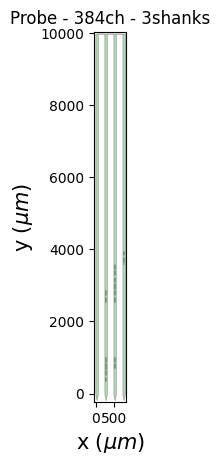

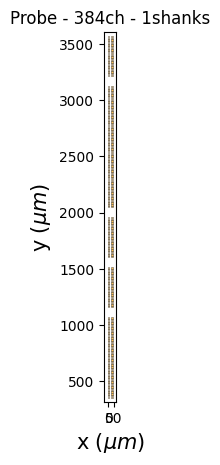

In [147]:
plot_probe(this_rec.get_probe());
plot_probe(p);

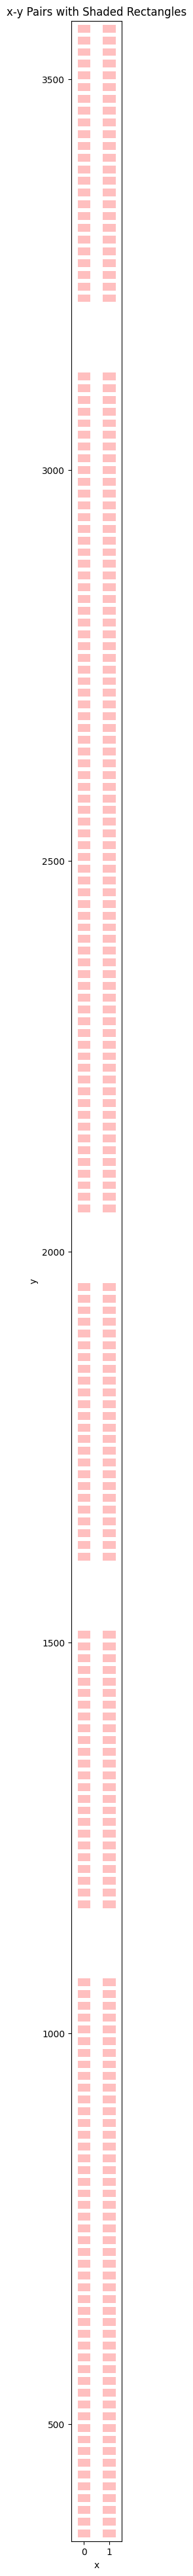

In [136]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plotting x-y pairs with shaded rectangles
fig, ax = plt.subplots(figsize=(1, 50))

# Define the size of the rectangles
rect_width = 0.5
rect_height = 10

# Plot each x-y pair as a rectangle
for _, row in stacked_df.iterrows():
    rect = patches.Rectangle((row['x'] - rect_width / 2, row['y'] - rect_height / 2),
                             rect_width, rect_height, linewidth=0, edgecolor='r', facecolor='r', alpha=0.25)
    ax.add_patch(rect)

# Set the limits of the plot
ax.set_xlim(stacked_df['x'].min() - rect_width, stacked_df['x'].max() + rect_width)
ax.set_ylim(stacked_df['y'].min() - rect_height, stacked_df['y'].max() + rect_height)

plt.xlabel('x')
plt.ylabel('y')
plt.title('x-y Pairs with Shaded Rectangles')
plt.show()


In [75]:
print("Block 0:")
print(sorted_df.iloc[0])
print("---")
counter=0
for i in range(1, len(sorted_df)):
    if sorted_df.iloc[i]['block'] != sorted_df.iloc[i-1]['block']:
        counter += 1
        print(sorted_df.iloc[i-1])
        print("\n")
        
        print(f"Block {counter}:")
        print(sorted_df.iloc[i])
        print("---")
print("Last block:")
print(sorted_df.iloc[-1])

Block 0:
x                  250.0
y                  360.0
contact_shapes    square
width               12.0
shank_ids              1
contact_ids        s1e48
block                  0
Name: 144, dtype: object
---
x                  250.0
y                 1065.0
contact_shapes    square
width               12.0
shank_ids              1
contact_ids       s1e142
block                  0
Name: 286, dtype: object


Block 1:
x                  250.0
y                 2520.0
contact_shapes    square
width               12.0
shank_ids              1
contact_ids       s1e336
block                  1
Name: 96, dtype: object
---
x                  250.0
y                 2865.0
contact_shapes    square
width               12.0
shank_ids              1
contact_ids       s1e382
block                  1
Name: 142, dtype: object


Block 2:
x                  282.0
y                  360.0
contact_shapes    square
width               12.0
shank_ids              1
contact_ids        s1e49
block       